### Boiler Plate Code

In [2]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from typing import List
from QAP_heuristic import QAP_heuristic
%matplotlib inline

In [3]:
# set up params for plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=SMALL)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=SMALL)       # controls default text sizes

In [12]:
# read in Tai35b test case to verify the model works
# for managing file opening and closing
def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

file_path = '../QAPInstances/tai12b.dat'
file_it = iter(read_integers(file_path))

# Number of points
n = next(file_it)

# Distance between locations
w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
d = np.array([[next(file_it) for j in range(n)] for i in range(n)])


##### Genetic Algorithm

We implement a genetic algorithm below. A couple of TODO's are as follows: 
- Initial Population Generation: The performance of a GA is sensitive to the quality of its initial population. Look at implementing GRASP - an algo for performing this 

In [30]:
class Genetic(QAP_heuristic):
    def __init__(self, w, d) -> None:
        super().__init__(w, d)
        self.seen = np.zeros((self.n, self.n))  # used for mutation
    
    ## Subroutines
    
    def generate_initial_population(self, population_size: int):
        # initially generates a population of random permutations
        return [np.random.permutation(self.n) for _ in range(population_size)]

    @staticmethod
    def selection(population: List[np.array]):
        # selects two parents from the population to crossover 
        # note that random.sample samples without replacement
        return random.sample(population,2)
    
    def mutate(self, perm: np.array):
        # swap two indices in place
        index1, index2 = random.randint(0, self.n-1), random.randint(0, self.n-1)

        temp = perm[index2]
        perm[index2] = perm[index1]
        perm[index1] = temp

        return perm

    def crossover(self, perm1: np.array, perm2: np.array):
        # implementation of partially-mapped-crossover 
        # copied from: github.com/DEAP/deap/blob/master/deap/tools/crossover.py
        
        size = self.n
        p1, p2 = [0] * size, [0] * size

        # Initialize the position of each indices in the individuals
        for k in range(size):
            p1[perm1[k]] = k
            p2[perm2[k]] = k
        
        # Choose crossover points
        cxpoint1 = random.randint(0, size)
        cxpoint2 = random.randint(0, size - 1)
        if cxpoint2 >= cxpoint1:
            cxpoint2 += 1
        else:  # Swap the two cx points
            cxpoint1, cxpoint2 = cxpoint2, cxpoint1

        # Apply crossover between cx points
        for k in range(cxpoint1, cxpoint2):
            # Keep track of the selected values
            temp1 = perm1[k]
            temp2 = perm2[k]
            # Swap the matched value
            perm1[k], perm1[p1[temp2]] = temp2, temp1
            perm2[k], perm2[p2[temp1]] = temp1, temp2
            # Position bookkeeping
            p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
            p2[temp1], p2[temp2] = p2[temp2], p2[temp1]
        
        # return the argmin of cost({ind1, ind2})
        return perm1 if self.cost(perm1) < self.cost(perm2)else perm2

    ## genetic algorithm
    def solve(self, n_iters: int):
        
        population = self.generate_initial_population()

        for _ in range(n_iters):
            pass

        return

In [32]:
test = Genetic(w,d)


### Verification

we verify the correctness of our implementation by plotting cost history on the following test instance 

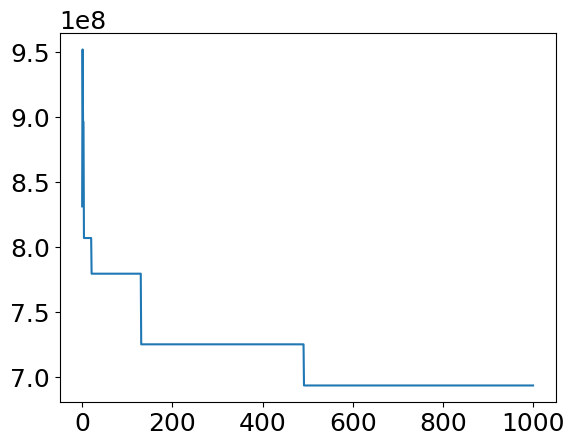

In [11]:
plt.plot(cost_hist)

### Automated Testing
code for automating the opening, closing and testing of a hueristic on every instance in QAPLib

In [34]:
instance_path = '../QAPInstances/'
soln_path     = '../QAPSolns/'

def open_solution(filename: str):
    file_it = iter(read_integers(filename))
    _ = next(file_it)    # this is just how the files within the lib are formatted
    return next(file_it)

        

def test_hueristic(n_iters=10_000, tai_only=False):
    """
    n_iters: number of iterations on each test instance
    tai_only: if True, restricts testing to the Tai instances, reducing computation time
    """
    
    results = [] # for storing results

    for filename in tqdm(os.listdir(instance_path)):
        
        # skips any instances that are not Tai
        if tai_only and 'tai' not in filename: continue  

        file_it = iter(read_integers(instance_path+filename))

        # open QAP instance param's 
        n = next(file_it)
        w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
        d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

        # generate an instance
        ils = IteratedLocalSearch(w, d)

        # open up corresponding soln from QAPLib: 
        soln_file = filename[:-4]+'.sln' # this removes the .dat from filename
        
        try:
            qap_soln = open_solution(soln_path+soln_file)
            huerstic_soln, _, _ = ils.iterated_local_search(n_iters)

            # compute gap
            gap = 100*(ils.cost(huerstic_soln) - qap_soln)/qap_soln
            results.append((soln_file, gap))
            

        # any instances without corresponding solution files are deleted
        except FileNotFoundError:
            os.remove(instance_path+filename) 
    
    # just printing results for now, but will need to save to file or something 
    print(results)

    return

In [35]:
test_hueristic(100, tai_only=True)

100%|██████████| 127/127 [33:34<00:00, 15.86s/it]

[('tai35b.sln', 78.23549542101385), ('tai15a.sln', 25.726017093664833), ('tai35a.sln', 23.588419827894445), ('tai15b.sln', 3.8462488014164244), ('tai80b.sln', 56.383199569316815), ('tai150b.sln', 32.53693050005149), ('tai80a.sln', 16.788451805679514), ('tai100a.sln', 13.888444232613889), ('tai25a.sln', 26.682578628852625), ('tai100b.sln', 51.454035638229065), ('tai25b.sln', 152.8699273889646), ('tai64c.sln', 62.27838579944912), ('tai12a.sln', 45.67588763724512), ('tai12b.sln', 128.34445523461656), ('tai50b.sln', 82.03367912233288), ('tai50a.sln', 18.061122589392234), ('tai30b.sln', 122.17745687832435), ('tai30a.sln', 18.272679971795444), ('tai40a.sln', 19.86124604618124), ('tai17a.sln', 26.549982513643425), ('tai256c.sln', 18.152913671962743), ('tai60b.sln', 79.92105782373483), ('tai40b.sln', 79.81296043517223), ('tai60a.sln', 18.199041293861942), ('tai20a.sln', 27.9901973326965), ('tai20b.sln', 122.77691179751857)]
